In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [2]:
cuda = True

In [3]:
batch_size = 256

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(35),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
trainset = torchvision.datasets.FashionMNIST(
    root      = './data/', 
    train     = True,
    download  = True,
    transform = transform
)
trainloader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2
)
testset = torchvision.datasets.FashionMNIST(
    root      = './data/', 
    train     = False,
    download  = True,
    transform = transform
)
testloader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2
)
classes = (
    'top',
    'trouser',
    'pullover',
    'dress',
    'coat',
    'sandal',
    'shirt',
    'sneaker',
    'bag',
    'boot'
)

In [6]:
def imshow(img):
    img   = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
dataiter       = iter(trainloader)
images, labels = dataiter.next()

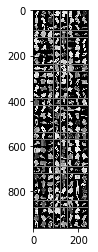

In [8]:
imshow(torchvision.utils.make_grid(images))

In [9]:
', '.join(classes[c] for c in labels)

'trouser, pullover, trouser, pullover, shirt, shirt, boot, shirt, coat, dress, shirt, coat, boot, boot, dress, top, trouser, trouser, sandal, sneaker, sneaker, trouser, dress, sandal, coat, pullover, coat, sneaker, top, top, boot, sandal, pullover, sandal, coat, dress, shirt, sneaker, coat, dress, coat, boot, sandal, bag, trouser, sneaker, coat, trouser, boot, sandal, sneaker, coat, top, coat, pullover, sneaker, top, dress, sneaker, shirt, bag, pullover, boot, coat, sneaker, boot, sneaker, dress, top, bag, sandal, bag, shirt, boot, bag, trouser, top, dress, pullover, sneaker, boot, top, bag, dress, pullover, trouser, trouser, bag, dress, bag, top, trouser, sneaker, bag, bag, sandal, sneaker, bag, coat, dress, boot, sandal, boot, trouser, shirt, bag, boot, boot, trouser, sandal, dress, coat, trouser, trouser, shirt, top, sneaker, boot, boot, sandal, sneaker, shirt, boot, pullover, top, boot, top, sandal, trouser, sneaker, sandal, boot, top, bag, shirt, shirt, bag, trouser, sneaker, trou

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1  , 64 , 3, padding = 1)
        self.conv2 = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv3 = nn.Conv2d(64 , 64 , 3, padding = 1)
        self.conv4 = nn.Conv2d(64 , 128 , 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding = 1)
        self.fc1   = nn.Linear(128 * 7 * 7, 512)
        self.fc2   = nn.Linear(512, 512)
        self.fc3   = nn.Linear(512, 512)
        self.fc4   = nn.Linear(512, 10)
        self.bn1   = nn.BatchNorm2d(64)
        self.bn2   = nn.BatchNorm2d(64)
        self.bn3   = nn.BatchNorm2d(64)
        self.bn4   = nn.BatchNorm2d(128)
        self.bn5   = nn.BatchNorm2d(128)
        self.bn6   = nn.BatchNorm2d(128)
        self.bn7   = nn.BatchNorm1d(512)
        self.bn8   = nn.BatchNorm1d(512)
        self.bn9   = nn.BatchNorm1d(512)
        
    def forward(self, x):
        x = F.dropout(F.relu(self.bn1(self.conv1(x))), 0.7)
        x = F.dropout(F.relu(self.bn2(self.conv2(x))), 0.7)
        x = F.dropout(F.relu(self.bn3(self.conv3(x))), 0.7)
        x = F.max_pool2d(x, (2, 2))
        x = F.dropout(F.relu(self.bn4(self.conv4(x))), 0.5)
        x = F.dropout(F.relu(self.bn5(self.conv5(x))), 0.5)
        x = F.dropout(F.relu(self.bn6(self.conv6(x))), 0.5)
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, 128 * 7 * 7)
        x = F.dropout(F.relu(self.bn7(self.fc1(x))), 0.3)
        x = F.dropout(F.relu(self.bn8(self.fc2(x))), 0.3)
        x = F.dropout(F.relu(self.bn9(self.fc3(x))), 0.3)
        x = self.fc4(x)
        
        return x

In [11]:
cnn       = CNN().cuda() if cuda else CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())
epoch     = 40
print_int = 100

In [12]:
def validate_model(train = True):
    cnn.eval()
    total_loss            = 0.0
    total_prediction      = 0
    total_good_prediction = 0
    batch_number          = 0
    for X, y in trainloader if train else testloader:
        X, y = Variable(X), Variable(y)
        X, y = (X.cuda(), y.cuda()) if cuda else (X, y)

        y_pred                 = cnn(X)
        total_loss            += criterion(y_pred, y).data[0]
        total_prediction      += y_pred.size()[0]
        total_good_prediction += (y_pred.max(dim = 1)[1].data.cpu() == y.data.cpu()).sum()
        batch_number          += 1
    
    return total_loss / batch_number, 100 * total_good_prediction / total_prediction 

In [13]:
for i in range(epoch):
    running_loss = 0
    for j, (X_train, y_train) in enumerate(trainloader):
        cnn.train()
        X_train, y_train = Variable(X_train), Variable(y_train)
        X_train, y_train = (X_train.cuda(), y_train.cuda()) if cuda else (X_train, y_train)
        
        optimizer.zero_grad()
        y_pred = cnn(X_train)
        loss   = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        if j % print_int == 0:
            train_loss, train_acc = validate_model(True)
            val_loss, val_acc     = validate_model(False)
            print(
                f'[{i + 1:<3}|{j:6}]'
                f'running_loss={running_loss.data[0] / (print_int if j != 0 else 1):.3f}, '
                f'train: loss={train_loss:.5f}, acc={train_acc:.2f}%|'
                f'val: loss={val_loss:.5f}, acc={val_acc:.2f}%'
            )
            running_loss = 0

[1  |     0]running_loss=2.329, train: loss=2.30273, acc=10.00%|val: loss=2.30270, acc=10.00%
[1  |   100]running_loss=0.604, train: loss=0.44544, acc=83.38%|val: loss=0.47631, acc=82.52%
[1  |   200]running_loss=0.407, train: loss=0.42736, acc=84.15%|val: loss=0.44549, acc=83.54%
[2  |     0]running_loss=0.408, train: loss=0.54275, acc=80.52%|val: loss=0.56804, acc=79.22%
[2  |   100]running_loss=0.342, train: loss=0.34125, acc=87.49%|val: loss=0.36880, acc=86.39%
[2  |   200]running_loss=0.321, train: loss=0.36695, acc=86.54%|val: loss=0.39521, acc=85.77%
[3  |     0]running_loss=0.333, train: loss=0.31866, acc=88.36%|val: loss=0.34598, acc=87.40%
[3  |   100]running_loss=0.290, train: loss=0.27339, acc=90.14%|val: loss=0.30633, acc=89.02%
[3  |   200]running_loss=0.285, train: loss=0.26173, acc=90.19%|val: loss=0.29155, acc=89.35%
[4  |     0]running_loss=0.283, train: loss=0.27016, acc=90.04%|val: loss=0.30160, acc=89.18%
[4  |   100]running_loss=0.264, train: loss=0.24401, acc=91.

[30 |   100]running_loss=0.107, train: loss=0.09886, acc=96.26%|val: loss=0.20632, acc=93.14%
[30 |   200]running_loss=0.106, train: loss=0.09877, acc=96.26%|val: loss=0.21319, acc=93.06%
[31 |     0]running_loss=0.104, train: loss=0.09871, acc=96.32%|val: loss=0.21449, acc=92.70%
[31 |   100]running_loss=0.101, train: loss=0.09404, acc=96.49%|val: loss=0.20317, acc=93.19%
[31 |   200]running_loss=0.108, train: loss=0.10240, acc=96.21%|val: loss=0.22745, acc=92.65%
[32 |     0]running_loss=0.069, train: loss=0.10077, acc=96.28%|val: loss=0.21508, acc=93.04%
[32 |   100]running_loss=0.102, train: loss=0.08979, acc=96.62%|val: loss=0.21483, acc=93.01%
[32 |   200]running_loss=0.104, train: loss=0.09878, acc=96.36%|val: loss=0.22582, acc=92.91%
[33 |     0]running_loss=0.130, train: loss=0.09868, acc=96.22%|val: loss=0.22179, acc=92.78%
[33 |   100]running_loss=0.099, train: loss=0.10692, acc=96.02%|val: loss=0.23360, acc=92.74%
[33 |   200]running_loss=0.100, train: loss=0.09717, acc=96.